In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time
from joblib import Parallel, delayed

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 600

In [3]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [4]:
f0 = 20
Mc = 3e-3* 2e30
f_max = 200
T_obs = 1e4
pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal
f_ratio = 25

In [5]:
beta

1.0714446596696796e-07

Generating signal and adding noise

In [6]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 0
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [7]:
# add real Gaussian noise and take real phase
# correct with known exact beta
# with some offsets

In [8]:
# %reset_selective -f "^signal$"
# %reset_selective -f noise
%reset_selective -f phi

In [8]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [10]:
def fft_plotter(data_temp, temp_time, xlim = [119.995, 120.005]):
    freqs = np.fft.fftshift(np.fft.fftfreq(len(temp_time), d=temp_time[1]-temp_time[0]))
    spec = np.fft.fftshift(np.fft.fft(data_temp))
    power_spec = np.abs(spec/len(temp_time))**2
    pl.plot(freqs[len(data_temp)//2:], power_spec[len(data_temp)//2:], alpha=0.7)
    pl.xlim(xlim[0], xlim[1])

In [22]:
noise_arr = [0, 10000]
freq_arr = []
spectrum_arr = []

for i in noise_arr:
    real_noise = np.random.normal(0, np.sqrt(i/2), nt)
    imag_noise = np.random.normal(0, np.sqrt(i/2), nt)
    noise = real_noise + 1j*imag_noise
    data = noise + signal
    
    freqs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]-t[0]))
    spec = np.fft.fftshift(np.fft.fft(data))
    power_spec = np.abs(spec/len(t))**2
    
    freq_arr.append(freqs[len(data)//2 : int(1.1*len(data)//2)])
    spectrum_arr.append(power_spec[len(data)//2 : int(1.1*len(data)//2)])
    
#     fft_plotter(data, t, xlim = [119.9, 121.1])
# pl.plot(data[0:1000], 'oz

(19.95, 20.05)

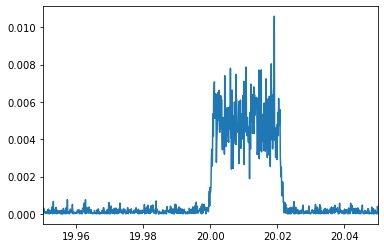

In [23]:
pl.plot(freq_arr[1], spectrum_arr[1])
pl.xlim(19.95, 20.05)

In [10]:
noise_arr = [0, 10000]

freq_arr = []
spectrum_arr = []
rs_freq_arr = []
rs_spectrum_arr = []

phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

for i in noise_arr:
    real_noise = np.random.normal(0, np.sqrt(i/2), nt)
    imag_noise = np.random.normal(0, np.sqrt(i/2), nt)
    noise = real_noise + 1j*imag_noise
    data = signal + noise
    
#     freqs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]-t[0]))
#     spec = np.fft.fftshift(np.fft.fft(data))
#     power_spec = np.abs(spec/len(t))**2
#     freq_arr.append(freqs[len(data)//2 : int(1.2*len(data)//2)])
#     spectrum_arr.append(power_spec[len(data)//2 : int(1.2*len(data)//2)])
    
    f_ratio = 25
    out, t_out = strobo(beta, data, f_ratio)
    corrected = np.fft.fftshift(np.fft.fft(out))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
    freq_corrected = freq_corrected[len(freq_corrected)//2 : int(1.1*len(data)//2)]
    corrected = corrected[len(corrected)//2 : int(1.1*len(data)//2)]
    resampled_power = np.abs(corrected/len(out))**2
    
    rs_freq_arr.append(freq_corrected)
    rs_spectrum_arr.append(resampled_power)

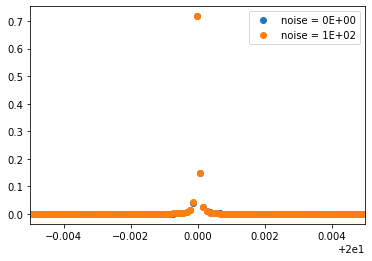

In [15]:
for i, val in enumerate(noise_arr):
    pl.plot(rs_freq_arr[i], rs_spectrum_arr[i], 'o', label = "noise = %.E" % val)
    pl.xlim(19.995, 20.005)
    
pl.legend()

In [15]:
height_ratio = np.max(spectrum_arr, axis = 1) / np.mean(spectrum_arr, axis = 1)
for i,val in enumerate(height_ratio):
    print("For noise amplitude = %.E the height ratio of signal:noise is %.1E" % (noise_arr[i], val))

For noise amplitude = 0E+00 the height ratio of signal:noise is 1.5E+06
For noise amplitude = 1E+02 the height ratio of signal:noise is 3.0E+04
For noise amplitude = 1E+03 the height ratio of signal:noise is 3.1E+03


In [9]:
noise_arr = [0, 10000]

freq_arr = []
spectrum_arr = []
rs_freq_arr = []
rs_spectrum_arr = []

phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

for i in noise_arr:
    real_noise = np.random.normal(0, np.sqrt(i/2), nt)
    imag_noise = np.random.normal(0, np.sqrt(i/2), nt)
    noise = real_noise + 1j*imag_noise
    data = signal + noise
    
    freqs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]-t[0]))
    spec = np.fft.fftshift(np.fft.fft(data))
    power_spec = np.abs(spec/len(t))**2
    freq_arr.append(freqs[len(data)//2 : int(1.1*len(data)//2)])
    spectrum_arr.append(power_spec[len(data)//2 : int(1.1*len(data)//2)])
    
    f_ratio = 25
    out, t_out = strobo(beta, data, f_ratio)
    corrected = np.fft.fftshift(np.fft.fft(out))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
    freq_corrected = freq_corrected[len(freq_corrected)//2 : int(1.1*len(data)//2)]
    corrected = corrected[len(corrected)//2 : int(1.1*len(data)//2)]
    resampled_power = np.abs(corrected/len(out))**2
    
    rs_freq_arr.append(freq_corrected)
    rs_spectrum_arr.append(resampled_power)

Text(0, 0.5, 'Power')

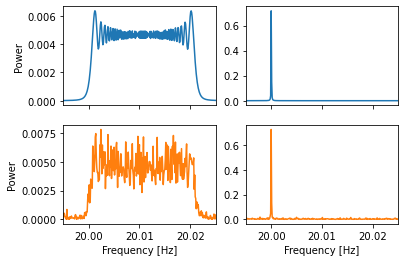

In [10]:
fig, axs = pl.subplots(2,2, sharex = True)

axs[0,0].plot(freq_arr[0], spectrum_arr[0])
axs[0,0].set_xlim(19.995, 20.025)

axs[0,1].plot(rs_freq_arr[0], rs_spectrum_arr[0])
axs[0,1].set_xlim(19.995, 20.025)

axs[1,0].plot(freq_arr[1], spectrum_arr[1], c='tab:orange')
axs[1,0].set_xlim(19.995, 20.025)

axs[1,1].plot(rs_freq_arr[1], rs_spectrum_arr[1], c='tab:orange')
axs[1,1].set_xlim(19.995, 20.025)

axs[1,0].set_xlabel("Frequency [Hz]")
axs[1,1].set_xlabel("Frequency [Hz]")
axs[0,0].set_ylabel("Power")
axs[1,0].set_ylabel("Power")

## Padding the data

In [18]:
def pad_calc(beta):
#     print(pad_len)
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    pad_frac = (pad_len - len(out)) / len(out)
    padded = np.full(pad_len, 0, dtype = complex)
    padded[:len(out)] = out
    pad_corrected = np.fft.fftshift(np.fft.fft(padded))
    pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
    pad_resampled_power = np.abs(pad_corrected/len(padded))**2
    
    arg_max = np.argmax(pad_resampled_power)
    peak_freq = pad_freq_corrected[arg_max]
    peak_power = pad_resampled_power[arg_max]
    return np.array([peak_freq, peak_power, pad_frac])

In [19]:
pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
pad_calc(beta+1e-4*beta)

array([-1.20000014e+02,  2.22244984e-01,  9.23540900e-03])

In [20]:
pad_len = int(334.4*T_obs) #~0.01 added length to resampled data
pad_calc(beta+1e-4*beta)

array([-1.20000014e+02,  2.07864087e-01,  4.35631440e-02])

In [21]:
%reset_selective -f new_t
%reset_selective -f padded
%reset_selective -f phi

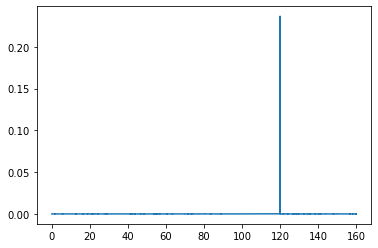

In [22]:
tic = time.time()

pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
pad_len_0 = pad_len
offset_arr = np.logspace(-8, -1, 100)
ref_freq_0, ref_power_0, _ = pad_calc(beta)

result_0 = np.array(Parallel(4)(delayed(pad_calc)(beta+i*beta) for i in offset_arr))
toc = time.time()
print((toc-tic)/60)

KeyboardInterrupt: 

In [ ]:
tic = time.time()

pad_len = int(502.4*T_obs) #~0.01 added length to resampled data
pad_len_1 = pad_len
offset_arr = np.logspace(-8, -1, 100)
ref_freq_1, ref_power_1, _ = pad_calc(beta)

result_1 = np.array(Parallel(4)(delayed(pad_calc)(beta+i*beta) for i in offset_arr))
toc = time.time()
print((toc-tic)/60)

In [ ]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, result_0[:,1]/ref_power_0, 'o', label = 'pad_frac=%.1F %%' % (100*result_0[0,2]))
pl.semilogx(offset_arr, result_1[:,1]/ref_power_1, 'o', label = 'pad_frac=%.1F %%' % (100*result_1[0,2]))
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.legend()
# pl.axvline(offset_arr[-40])
pl.show()